# Synhtèse 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write

from IPython.display import display, Audio

################################################################################################
# Définition des paramètres de la corde
L = 0.65                            # Longueur de la corde en mètres
rho = 1100.0                        # Densité de la corde en kg/m^3
a = (0.96/2)*1e-3                   # rayon de la corde en m
T = 144.0                           # Tension de la corde en N
k = 2.23e7                          # Raideur de la corde en N/m
m = 0.79                            # Masse linéique
E = 12e9                            # Module d'Young
I =(np.pi*(a**4))/4
Zo = 0.339                          # Impédance de corde
A = np.sqrt(2/(np.pi*rho*L*(a**2))) # Amplitude normalisée des modes

# Définition des paramètres de simulation
N = 100                             # Nombre de modes de vibration
Fs = 44100                          # Fréquence d'échantillonnage en Hz
dt = 1/Fs
duration = 5.0                      # Durée de la simulation en secondes
t = np.linspace(0, duration, int(duration*Fs), endpoint=False)


################################################################################################
# Calcul des fréquences et des amplitudes des modes de vibration
f_1 = (T/m)*((1/(2*L))**2)          #Fréquence fondamentale de la corde au carré


f = np.zeros(N)
un = np.zeros(N)
for n in range(1, N+1):
    f[n-1] = ((n**2)*f_1) + ((E *(n**4)*(np.pi**2)*(a**2))/(16*rho*(L**4))) #fréquences propres inharmoniques
    un[n-1] = A*np.sin(n*np.pi)     #Forme des modes au point L
omega = 2*np.pi*f                   #Pulsations propres

################################################################################################
# Calcul des coefficients d'amortissement de Woodhouse
eta = np.zeros(N)

eta_a = 1.48e-5 # kinematic viscosity of air
rho_a = 1.293 # density of air
eta_e = 1e-2 #partie imaginaire du module d'Young
E= E*(1+(1j*eta_e))
Z_body = 3000
for n in range(1, N):
    #frottement de l'air
    M = 0.5*a*np.sqrt((2*np.pi*f[n])/eta_a)
    eta_air = (rho_a/rho)*((M**2)/((2*np.sqrt(2)*M) +1))
    
    # Amortissement de structure
    eta_body = (2*Zo)/(np.pi*(n)*Z_body)
    
    #Amortissement viscoélastique de corde
    eta_bend = (E*eta_e*I)/T *((((n)*np.pi)/L)**2)
    
    eta[n-1] = eta_air+eta_body+eta_bend

################################################################################################
# Définition des conditions initiales en déplacement et en vitesse
P = 10.0  # Force appliquée en newtons
y0 = (P*L/T) * np.ones(N) / np.sqrt(np.sum(A**2))  # Déplacement initial
v0 = np.zeros(N)  # Vitesse initiale
x0 = 0.5*L       #point de pincement


#Résolution de l'accélération du corps de la guitare au point de couplage
y = np.zeros(len(t))
const = - 8*np.pi * f_1 *P/Z_body
a = np.zeros(t.shape)
for i, time in enumerate(t):
    a[i] = const *np.sum((np.arange(1,N+1)*np.sin(np.pi*x0*np.arange(1,N+1)) / omega) *  np.sin(omega *time) *  np.exp(-omega*eta*0.5*time))

C:\Users\lam\AppData\Local\Temp\ipykernel_16228\2130130969.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  eta[n-1] = eta_air+eta_body+eta_bend


In [11]:
#Intégration du signal

import numpy as np

def trapezoidal_integration(y, dt):
    # Calcule l'intégrale numérique en utilisant la méthode des trapèzes
    integral = 0.5 * dt * (y[0] + y[-1] + 2*np.sum(y[1:-1]))
    return integral

# Exemple d'utilisation pour intégrer l'accélération pour obtenir le déplacement

deplacement_trapezoidal = np.zeros_like(a)  # Intégration numérique en utilisant la méthode des trapèzes
for i in range(1, len(a)):
    deplacement_trapezoidal[i] = trapezoidal_integration(a[:i+1], 1/Fs)
    
# Affichage des résultats
print("Déplacement calculé avec la méthode des trapèzes : ", deplacement_trapezoidal)

Déplacement calculé avec la méthode des trapèzes :  [ 0.00000000e+00  1.39169376e-08  3.14984282e-08 ... -1.58121279e-05
 -1.57971263e-05 -1.57820553e-05]


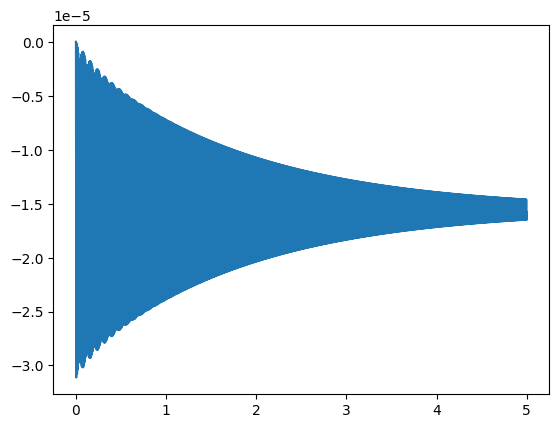

In [12]:
plt.plot(t,deplacement_trapezoidal)
display(Audio(deplacement_trapezoidal,rate=Fs)) # Listening all song